In [1]:
%load_ext autoreload
%autoreload 2


import numpy as np
import sys

import matplotlib.pyplot as plt  
import seaborn as sns
import figures as figs
import calculations
from types import SimpleNamespace
import pandas as pd
import pandasdmx as sdmx

from pandasdmx import Request
import pandas as pd
import matplotlib.pyplot as plt

# Ploting jacobians wrt ptilde
from matplotlib.ticker import FormatStrFormatter

import gc  # For garbage collection
import itertools


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


from seaborn import set_palette
from matplotlib import rc
plt.style.use('seaborn-v0_8-white')
set_palette("colorblind")
rc('font',**{'family':'serif','serif': ['Palatino']})
rc('text',usetex=True)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

# Should make insure text size in latex mode
# plt.rcParams.update({
#     "text.latex.preamble": r"\usepackage{palatino} \normalsize"
# })

from IHANKModel import IHANKModelClass

from pandasdmx import Request
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates





/Users/emmagundersen/opt/anaconda3/lib/python3.9/site-packages/pandasdmx/remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  warn(


In [2]:
new_fig = True

# Data / motivation

**Inflation**

2025-08-15 10:40:32,115 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-08-15 10:40:32,226 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-08-15 10:40:32,333 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message
2025-08-15 10:40:32,441 pandasdmx.reader.sdmxml - INFO: Use supplied dsd=… argument for non–structure-specific message


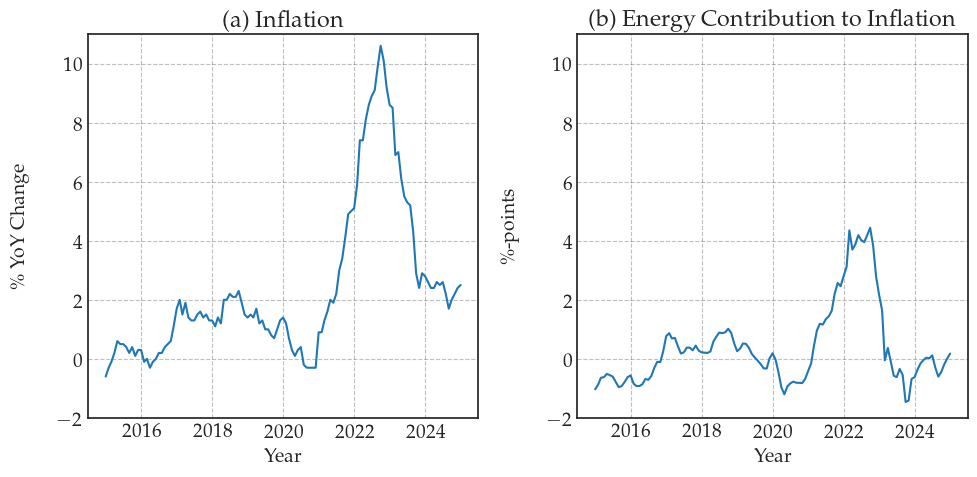

In [54]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from pandasdmx import Request

estat = Request('ESTAT')

# --- 1. Inflation data ---
inflation_resp = estat.data(
    resource_id='PRC_HICP_MANR',
    key={'geo': 'EA', 'coicop': 'CP00', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_inflation = inflation_resp.to_pandas().reset_index()
df_inflation['TIME_PERIOD'] = pd.to_datetime(df_inflation['TIME_PERIOD'])
df_inflation['value'] = df_inflation['value'].astype(float)

# --- 2. Energy share by quintile ---
energy_resp = estat.data(
    resource_id='ICW_AFF_01',
    key={
        'geo': 'EU',
        'coicop': ['CP00', 'CP045', 'CP0722'],
        'quant_inc': ['QU1', 'QU2', 'QU3', 'QU4', 'QU5']
    },
    params={'startPeriod': '2015', 'endPeriod': '2015'}
)
df_energy = energy_resp.to_pandas().reset_index()
quintile_order = ['QU1', 'QU2', 'QU3', 'QU4', 'QU5']
df_energy['quant_rank'] = df_energy['quant_inc'].apply(lambda q: quintile_order.index(q) + 1)
df_pivot = df_energy.pivot(index='quant_inc', columns='coicop', values='value').reset_index()
df_pivot['energy_total'] = df_pivot['CP045'] + df_pivot['CP0722']
df_pivot['energy_share'] = df_pivot['energy_total'] / df_pivot['CP00'] * 100
df_pivot['quant_rank'] = df_pivot['quant_inc'].apply(lambda q: quintile_order.index(q) + 1)
df_pivot = df_pivot.sort_values('quant_rank')

# --- 3. Energy prices ---
prices_resp = estat.data(
    resource_id='PRC_HICP_MANR',
    key={'geo': 'EA', 'coicop': 'NRG', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_prices = prices_resp.to_pandas().reset_index()
df_prices['TIME_PERIOD'] = pd.to_datetime(df_prices['TIME_PERIOD'])
df_prices['value'] = df_prices['value'].astype(float)

# --- Additional data: Energy contribution to inflation ---
contrib_resp = estat.data(
    resource_id='PRC_HICP_CTRB',
    key={'geo': 'EA', 'coicop': 'NRG', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_contrib = contrib_resp.to_pandas().reset_index()
df_contrib['TIME_PERIOD'] = pd.to_datetime(df_contrib['TIME_PERIOD'])
df_contrib['value'] = df_contrib['value'].astype(float)

# --- Modify Subplot 1 to include energy contribution ---
fig = plt.figure(figsize=(10, 5))

# Subplot 1: Inflation
ax1 = fig.add_subplot(121)
ax1.plot(df_inflation['TIME_PERIOD'], df_inflation['value'], color='tab:blue', label='Overall Inflation')
# ax1.plot(df_contrib['TIME_PERIOD'], df_contrib['value'], color='tab:red', linestyle='--', label='Energy Contribution')
ax1.set_title('(a) Inflation')
ax1.set_xlabel('Year')
ax1.set_ylabel(r'\% YoY Change')
ax1.yaxis.set_label_coords(-0.15, 0.5)
ax1.set_ylim(-2, 11)
# ax1.legend()

# # Subplot 2: Energy expenditure share
# ax2 = fig.add_subplot(133)
# ax2.bar(df_pivot['quant_rank'], df_pivot['energy_share'], color='tab:blue')
# ax2.set_xticks([1, 2, 3, 4, 5])
# ax2.set_xticklabels([1, 2, 3, 4, 5])
# ax2.set_title('(c) Energy Expenditure Share')
# ax2.set_xlabel('Income Quintile')
# ax2.set_ylabel(r'\% of Expenditure')
# ax2.yaxis.set_label_coords(-0.15, 0.5)

# Subplot 3: Energy prices
ax3 = fig.add_subplot(122)
# ax3.plot(df_prices['TIME_PERIOD'], df_prices['value'], color='tab:blue')
ax3.plot(df_contrib['TIME_PERIOD'], df_contrib['value'], color='tab:blue',  label='Energy Contribution')
ax3.set_title('(b) Energy Contribution to Inflation')
ax3.set_xlabel('Year')
ax3.set_ylabel(r'\%-points ')
ax3.yaxis.set_label_coords(-0.15, 0.5)
ax3.set_ylim(-2, 11)

# Final layout
fig.subplots_adjust(left=0.08, right=0.98, wspace=0.3)
fig.tight_layout()
if new_fig:  fig.savefig('plots_defence/intro_figure.png', dpi=300, bbox_inches='tight')



In [ ]:

estat = Request('ESTAT')

# --- 1. Inflation data ---
inflation_resp = estat.data(
    resource_id='PRC_HICP_MANR',
    key={'geo': 'EA', 'coicop': 'CP00', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_inflation = inflation_resp.to_pandas().reset_index()
df_inflation['TIME_PERIOD'] = pd.to_datetime(df_inflation['TIME_PERIOD'])
df_inflation['value'] = df_inflation['value'].astype(float)

# --- 2. Energy share by quintile ---
energy_resp = estat.data(
    resource_id='ICW_AFF_01',
    key={
        'geo': 'EU',
        'coicop': ['CP00', 'CP045', 'CP0722'],
        'quant_inc': ['QU1', 'QU2', 'QU3', 'QU4', 'QU5']
    },
    params={'startPeriod': '2015', 'endPeriod': '2015'}
)
df_energy = energy_resp.to_pandas().reset_index()
quintile_order = ['QU1', 'QU2', 'QU3', 'QU4', 'QU5']
df_energy['quant_rank'] = df_energy['quant_inc'].apply(lambda q: quintile_order.index(q) + 1)
df_pivot = df_energy.pivot(index='quant_inc', columns='coicop', values='value').reset_index()
df_pivot['energy_total'] = df_pivot['CP045'] + df_pivot['CP0722']
df_pivot['energy_share'] = df_pivot['energy_total'] / df_pivot['CP00'] * 100
df_pivot['quant_rank'] = df_pivot['quant_inc'].apply(lambda q: quintile_order.index(q) + 1)
df_pivot = df_pivot.sort_values('quant_rank')

# --- 3. Energy prices ---
prices_resp = estat.data(
    resource_id='PRC_HICP_MANR',
    key={'geo': 'EA', 'coicop': 'NRG', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_prices = prices_resp.to_pandas().reset_index()
df_prices['TIME_PERIOD'] = pd.to_datetime(df_prices['TIME_PERIOD'])
df_prices['value'] = df_prices['value'].astype(float)

# --- Additional data: Energy contribution to inflation ---
contrib_resp = estat.data(
    resource_id='PRC_HICP_CTRB',
    key={'geo': 'EA', 'coicop': 'NRG', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_contrib = contrib_resp.to_pandas().reset_index()
df_contrib['TIME_PERIOD'] = pd.to_datetime(df_contrib['TIME_PERIOD'])
df_contrib['value'] = df_contrib['value'].astype(float)




# --- Modify Subplot 1 to include energy contribution ---

fig = plt.figure(figsize=(5, 5))

# Subplot 1: Inflation
ax1 = fig.add_subplot(111)
ax1.plot(df_inflation['TIME_PERIOD'], df_inflation['value'],  label='Overall Inflation')

ax1.set_xlabel('Year')
ax1.set_ylabel(r'\% YoY Change')

fig.tight_layout()
if new_fig:  fig.savefig('plots_defence/inflation.png', dpi=300, bbox_inches='tight')



**Energy Contribution to infltion**

In [ ]:

estat = Request('ESTAT')

# --- 1. Inflation data ---
inflation_resp = estat.data(
    resource_id='PRC_HICP_MANR',
    key={'geo': 'EA', 'coicop': 'CP00', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_inflation = inflation_resp.to_pandas().reset_index()
df_inflation['TIME_PERIOD'] = pd.to_datetime(df_inflation['TIME_PERIOD'])
df_inflation['value'] = df_inflation['value'].astype(float)

# --- 2. Energy share by quintile ---
energy_resp = estat.data(
    resource_id='ICW_AFF_01',
    key={
        'geo': 'EU',
        'coicop': ['CP00', 'CP045', 'CP0722'],
        'quant_inc': ['QU1', 'QU2', 'QU3', 'QU4', 'QU5']
    },
    params={'startPeriod': '2015', 'endPeriod': '2015'}
)
df_energy = energy_resp.to_pandas().reset_index()
quintile_order = ['QU1', 'QU2', 'QU3', 'QU4', 'QU5']
df_energy['quant_rank'] = df_energy['quant_inc'].apply(lambda q: quintile_order.index(q) + 1)
df_pivot = df_energy.pivot(index='quant_inc', columns='coicop', values='value').reset_index()
df_pivot['energy_total'] = df_pivot['CP045'] + df_pivot['CP0722']
df_pivot['energy_share'] = df_pivot['energy_total'] / df_pivot['CP00'] * 100
df_pivot['quant_rank'] = df_pivot['quant_inc'].apply(lambda q: quintile_order.index(q) + 1)
df_pivot = df_pivot.sort_values('quant_rank')

# --- 3. Energy prices ---
prices_resp = estat.data(
    resource_id='PRC_HICP_MANR',
    key={'geo': 'EA', 'coicop': 'NRG', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_prices = prices_resp.to_pandas().reset_index()
df_prices['TIME_PERIOD'] = pd.to_datetime(df_prices['TIME_PERIOD'])
df_prices['value'] = df_prices['value'].astype(float)

# --- Additional data: Energy contribution to inflation ---
contrib_resp = estat.data(
    resource_id='PRC_HICP_CTRB',
    key={'geo': 'EA', 'coicop': 'NRG', 'freq': 'M'},
    params={'startPeriod': '2015-01', 'endPeriod': '2025-01'}
)
df_contrib = contrib_resp.to_pandas().reset_index()
df_contrib['TIME_PERIOD'] = pd.to_datetime(df_contrib['TIME_PERIOD'])
df_contrib['value'] = df_contrib['value'].astype(float)

# --- Modify Subplot 1 to include energy contribution ---
fig = plt.figure(figsize=(5, 5))



# Subplot 3: Energy prices
ax3 = fig.add_subplot(111)
ax3.plot(df_contrib['TIME_PERIOD'], df_contrib['value'],   label='Energy Contribution')

ax3.set_xlabel('Year')
ax3.set_ylabel(r'\%-points ')


# Final layout

fig.tight_layout()
if new_fig:  fig.savefig('plots_defence/inflation_energy_contribution.png', dpi=300, bbox_inches='tight')



**Inflation Inequality**

In [ ]:
# a. Data 

path = '/Users/emmagundersen/Desktop/Current code/I_HANK_PIGL-1/Composition_COL_inequality.xlsx'

# Load the Excel file without headers
df = pd.read_excel(path, header=None, sheet_name='Sheet1')

# Drop the first row
df = df.iloc[1:].reset_index(drop=True)

# Set the second row as header
df.columns = df.iloc[0]
df = df.drop(df.index[0]).reset_index(drop=True)

# Rename and convert the date column
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%YM%m')

# # Add a collum with sum
df['Sum'] = df.iloc[:, 1:].sum(axis=1)


# Make sure dataframe is sorted by date
df = df.sort_values('Date').reset_index(drop=True)

In [ ]:
# Plot
fig, ax = plt.subplots(figsize=(5, 5))

# df.plot(x='Date', y=['sum'])

ax.plot(df['Date'], df['Sum'],  label='Total Contribution')

# ax.set_title('Cost of living inequality')
ax.set_ylabel(r'\%-points ')

ax.set_xlabel('Year')

ax.set_xlim(pd.to_datetime('2015-01-01'))#, pd.to_datetime('2025-01-01'))

# every second year only year
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

fig.tight_layout()
if new_fig:  fig.savefig('plots_defence/col_inequality.png', dpi=300, bbox_inches='tight')


# Note Difference in inflation rates between households in the top 20% and the bottom 20% of equivalized household income.

In [ ]:

# categories to plot
cats = [c for c in df.columns if c not in ['Date', 'Sum']]

# use default matplotlib color cycle
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# --- b. Figure -------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 5))

x = df['Date']
bar_width = 25  # days

pos_stack = np.zeros(len(df))
neg_stack = np.zeros(len(df))

for i, cat in enumerate(cats):
    y = df[cat].astype(float).to_numpy()
    pos = np.where(y > 0, y, 0)
    neg = np.where(y < 0, y, 0)

    ax.bar(x, pos, width=bar_width, bottom=pos_stack,
           label=cat, color=color_cycle[i % len(color_cycle)])
    pos_stack += pos

    ax.bar(x, neg, width=bar_width, bottom=neg_stack,
           color=color_cycle[i % len(color_cycle)])
    neg_stack += neg


ax.set_ylabel(r'\%-points ')

# x axis
start = pd.Timestamp('2016-01-01')
end   = pd.Timestamp('2024-12-31')
ax.set_xlim(start)#, end)

# ax.xaxis.set_major_locator(mdates.YearLocator(2))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
# ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))


ax.set_xlabel('Year')

# legend outside right
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=False)

fig.tight_layout()

if new_fig:  
    fig.savefig('plots_defence/col_inequality_dec.png', dpi=300, bbox_inches='tight')



# Impirical relevance of NH preferences


In [ ]:
estat = Request('ESTAT')
# Dictionaries 
coicops = [
    'CP011', 'CP012', 'CP021', 'CP022', 'CP031', 'CP032',
    # 'CP041', 'CP042',
     'CP043', 'CP044', 'CP045',
    'CP051', 'CP052', 'CP053', 'CP054', 'CP055', 'CP056',
    'CP061', 'CP062', 'CP063',
    'CP071', 'CP072', 'CP073',
    'CP081', 'CP082', 'CP083',
    'CP091', 'CP092', 'CP093', 'CP094', 'CP095', 'CP096',
    'CP111', 'CP112',
    'CP121', 'CP122', 'CP123', 'CP124', 'CP125', 'CP126', 'CP127'
]

# Rent Actual CP041
# Imputed rents for housing CP042 (Not tradable)

coicop_tradable = {
    'CP011': True, 'CP012': True, 'CP021': True, 'CP022': True,
    'CP031': True, 'CP032': True,
    # 'CP041': False, 'CP042': False,
     'CP043': False, 'CP044': False, 'CP045': True,
    'CP051': True, 'CP052': True, 'CP053': True, 'CP054': True, 'CP055': True, 'CP056': True,
    'CP061': True, 'CP062': False, 'CP063': False,
    'CP071': True, 'CP072': False, 'CP073': False,
    'CP081': False, 'CP082': True, 'CP083': False,
    'CP091': True, 'CP092': True, 'CP093': True, 'CP094': False, 'CP095': True, 'CP096': True,
    'CP111': False, 'CP112': False,
    'CP121': False, 'CP122': False, 'CP123': False, 'CP124': False, 'CP125': False, 'CP126': False, 'CP127': False
}

# Year and countries 
year = '2015'
geos = [

    'AT',  # Austria
    'BE',  # Belgium
    'CY',  # Cyprus
    'EE',  # Estonia
    'FI',  # Finland
    'FR',  # France
    'DE',  # Germany
    'EL',  # Greece
    'IE',  # Ireland
    'IT',  # Italy
    'LV',  # Latvia
    'LT',  # Lithuania
    'LU',  # Luxembourg
    'MT',  # Malta
    'NL',  # Netherlands
    'PT',  # Portugal
    'SK',  # Slovakia
    'SI',  # Slovenia
    'ES'   # Spain
]

country_names = {
    'AT': 'Austria',
    'BE': 'Belgium',
    'BG': 'Bulgaria',
    'HR': 'Croatia',
    'CY': 'Cyprus',
    'CZ': 'Czechia',
    'DK': 'Denmark',
    'EE': 'Estonia',
    'FI': 'Finland',
    'FR': 'France',
    'DE': 'Germany',
    'GR': 'Greece',
    'HU': 'Hungary',
    'IE': 'Ireland',
    'IT': 'Italy',
    'LV': 'Latvia',
    'LT': 'Lithuania',
    'LU': 'Luxembourg',
    'MT': 'Malta',
    'NL': 'Netherlands',
    'PL': 'Poland',
    'PT': 'Portugal',
    'RO': 'Romania',
    'SK': 'Slovakia',
    'SI': 'Slovenia',
    'ES': 'Spain',
    'SE': 'Sweden'
}


# --- Step 1: Download data ---
data_list = []

for geo in geos:
    for coicop in coicops:
        try:
            data = estat.data(
                resource_id='HBS_STR_T223',
                key={'geo': geo, 'coicop': coicop},
                params={'startPeriod': year, 'endPeriod': year}
            )
            df = data.to_pandas().reset_index()
            df['coicop'] = coicop
            df['geo'] = geo
            data_list.append(df)
        except Exception as e:
            print(f"Error for {geo}-{coicop}: {e}")

# --- Step 2: Combine and filter ---
df_all = pd.concat(data_list, ignore_index=True)
df_all = df_all[df_all['quantile'].str.startswith('QUINTILE')]
df_all['quantile_num'] = df_all['quantile'].str.extract(r'QUINTILE(\d)').astype(int)
df_all['tradable'] = df_all['coicop'].map(coicop_tradable)

# --- Step 3: Aggregations ---

# Total spending
total = df_all.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='total_value')

# Non-tradable spending
nontrad = df_all[~df_all['tradable']].groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='nontrad_value')

# Energy spending (CP045)
energy_df = df_all[df_all['coicop'] == 'CP045']
energy_grouped = energy_df.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='energy_value')

# energy = energy_df.groupby(['geo', 'quantile_num'])['value'].sum().reset_index(name='energy_value')

# --- Step 4: Merge everything ---
df_merged = pd.merge(total, nontrad, on=['geo', 'quantile_num'], how='left')
df_merged = pd.merge(df_merged, energy_grouped, on=['geo', 'quantile_num'], how='left')


# # --- Step 5: Compute shares ---
df_merged['nontrad_value'] = df_merged['nontrad_value'].fillna(0)
df_merged['energy_value'] = df_merged['energy_value'].fillna(0)

df_merged['nontrad_share'] = (df_merged['nontrad_value'] / df_merged['total_value'])*100
df_merged['energy_share'] = (df_merged['energy_value'] / df_merged['total_value'])*100

# # --- Download top cut-off point data from ilc_di01 ---
# response = estat.data(
#     resource_id='ILC_DI01',
#     key={
#         'indic_il': 'TC',        # Top cut-off point
#         'quantile': ['QU1', 'QU2', 'QU3', 'QU4', 'QU5'],  # Income quintiles
#         'geo': geos              # use your list of countries
#     },
#     params={'startPeriod': '2015', 'endPeriod': '2015'}
# )

# # Convert to DataFrame
# income_df = response.to_pandas().reset_index()
# # income_df


# # # Clean and rename
# income_df['quantile_num'] = income_df['quantile'].str.extract(r'QU(\d)').astype(int)
# income_df = income_df[['geo', 'quantile_num', 'value']]
# income_df.rename(columns={'value': 'income'}, inplace=True)
# income_df

response = estat.data(
    resource_id='ILC_DI01',
    key={
        'indic_il': 'TC',  # Top cut-off point
        'quantile': ['D1', 'D3', 'D5', 'D7', 'D9'],
        'geo': geos
    },
    params={'startPeriod': '2015', 'endPeriod': '2015'}
)

# Convert and clean
income_df = response.to_pandas().reset_index()
income_df['quintile_num'] = income_df['quantile'].str.extract(r'D(\d)').astype(int)
income_df['quintile_num'] = income_df['quintile_num'].replace({
    1: 1,
    3: 2,
    5: 3,
    7: 4,
    9: 5
})
income_df = income_df[['geo', 'quintile_num', 'currency', 'value']]
income_df.rename(columns={'value': 'income', 'quintile_num':'quantile_num'}, inplace=True)
income_df = income_df[income_df['currency'] == 'EUR']

# df_final['country_name'] = df_final['geo'].map(country_names)
df_final = pd.merge(
    df_merged,
    income_df[['geo', 'quantile_num', 'income']],
    on=['geo', 'quantile_num'],
    how='inner'
)# Merged 


In [ ]:


fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1,2,1)

for geo in df_final['geo'].unique():
    country_data = df_final[df_final['geo'] == geo].sort_values('income')
    name = country_names.get(geo, geo)  # full name or fallback to code

    # Plot scatter points for quantiles
    ax.scatter(
        country_data['income'],
        country_data['nontrad_share'] ,
        # label=name
    )

    # Draw straight line from first to last point
    x_vals = [country_data['income'].iloc[0], country_data['income'].iloc[-1]]
    y_vals = [(country_data['nontrad_share'] ).iloc[0],
              (country_data['nontrad_share'] ).iloc[-1]]
    ax.plot(x_vals, y_vals, linestyle='-', linewidth=1)

# Set labels, limits, and legend
ax.set_xlim(0, 45000)
ax.set_xlabel('Income (EUR) — 2015')
ax.set_ylabel('Consumption share (\%)')
ax.set_title('Non-tradable Goods')
ax.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
# ax.set_xlabel('Top Cut-off Disposable Income (EUR) — 2015')
# ax.set_ylabel('Non-tradable consumption share (%)')
# ax.set_title('Non-tradable Consumption Shares by Income Quantile (EU, 2015)')



ax = fig.add_subplot(1,2,2)

for geo in df_final['geo'].unique():
    country_data = df_final[df_final['geo'] == geo].sort_values('income')
    name = country_names.get(geo, geo)  # full name or fallback to code

    # Plot scatter points (quantiles)
    ax.scatter(
        country_data['income'],
        country_data['energy_share'] ,
        label=name
    )

    # Draw a single line from first to last point
    x_vals = [country_data['income'].iloc[0], country_data['income'].iloc[-1]]
    y_vals = [(country_data['energy_share'] ).iloc[0],
              (country_data['energy_share'] ).iloc[-1]]

    ax.plot(x_vals, y_vals, linestyle='-', linewidth=1)

# Set labels, limits, and legend
ax.set_xlim(0, 45000)
ax.set_xlabel('Income (EUR) — 2015')
ax.set_ylabel('Consumption share (\%)')
ax.set_title('Energy')
ax.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')



plt.tight_layout()

if new_fig:  
    fig.savefig('plots_defence/consumption_shares_data.png', dpi=300, bbox_inches='tight')


# PIGL 

In [ ]:

# Plotting expenditure shares
c = {'T': 'r', 'NT': 'b'}

# Define your functions
def calc_CT(par, e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    return CT

def calc_CNT(par,e, PT=1, PNT=1):
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    return CNT



def share_T(par,e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)  
    return CT/(CT+CNT) 

def share_NT(par, e, PT=1, PNT=1):
    CT = (e/PT)*(par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)
    CNT = (e/PNT)*(1-par.nu*(PNT/e)**par.epsilon*(PT/PNT)**par.gamma)  
    return CNT/(CT+CNT)

def exp_shareT(par,e, PT=1, PNT=1):
    omega_T = par.nu *(PNT/e)**par.epsilon*(PT/PNT)**par.gamma
    return omega_T

def exp_shareNT(par,e, PT=1, PNT=1):
    omega_NT = 1-par.nu *(PNT/e)**par.epsilon*(PT/PNT)**par.gamma
    return omega_NT

def utility_indirect(par,e, PT=1, PNT=1):
    utility = (1/par.epsilon) * ( (e/PNT)**par.epsilon -1) - (par.nu/par.gamma)*( (PT/PNT)**par.gamma -1)
    return utility

def mu_e(par,e, PT=1, PNT=1):
    mu_e = PNT**(-par.epsilon) * e**(- (1-par.epsilon))
    return mu_e
    
# mapar.
# nualy calculating mu_e to check if it is correct
def mu_e_maual(par,e, PT=1, PNT=1):
    utility = utility_indirect(e, PT, PNT, par.nu, par.epsilon, par.gamma)
    utility_plus_1 = utility_indirect(e*1.01, PT, PNT, par.nu, par.epsilon, par.gamma)
    mu_e = (utility_plus_1 - utility) / (0.01*e)
    return mu_e

def calc_cost_of_living(par, e, PT=1, PNT=1):

    omega_T = exp_shareT(par, e, PT=1, PNT=1)

    p_tilde = ((1-(par.epsilon*omega_T)/par.gamma)*PNT**par.gamma + ((par.epsilon*omega_T)/par.gamma)*PT**par.gamma)**(1/par.gamma)
    p_index = p_tilde**(par.gamma/par.epsilon)*PNT**(1-(par.gamma/par.epsilon))


    return p_index

def calc_cost_of_living_new_eq(par, e, PT=1, PNT=1):

    omega_T = exp_shareT(par, e, PT=1, PNT=1)

    # If epsilon = 0
    if par.epsilon == 0:
                # Limiting case as epsilon -> 0, with P_T,s = P_NT,s = 1
        rel_ratio = (PT / PNT) ** par.gamma
        exponent = omega_T * rel_ratio * (1 / par.gamma) * (rel_ratio - 1)
        p_index = PNT * np.exp(exponent)
    else:
        p_index = PNT *(1+omega_T*(par.epsilon/par.gamma)*((PT/PNT)**par.gamma-1))**(1/par.epsilon)

    return p_index


def calc_cost_of_living_diff(par, e, PT=1, PNT=1):

    p_index = calc_cost_of_living(par, e, PT, PNT)
    pct_change = (p_index - 1)*100    

    return pct_change

# Calculating the non constant elasticity of substitution
def calc_NCES(par, e, PT=1, PNT=1):

    elasticity = 1 - par.gamma - (par.nu*(PT/PNT)**par.gamma) / ( (e/PNT)**par.epsilon - par.nu*(PT/PNT)**par.gamma) * (par.gamma - par.epsilon)

    return elasticity

def calc_NCES_alt(par, e, PT=1, PNT=1):
    omega_T = exp_shareT(par, e, PT=1, PNT=1)
    omega_NT = exp_shareNT(par, e, PT=1, PNT=1)

    elasticity = 1 - par.gamma - (omega_T /omega_NT ) * (par.gamma - par.epsilon)

    return elasticity


def calc_E(par, e,  PT=1, PNT=1, PE=1):
    CT =  calc_CT(par, e, PT, PNT)
    # CES nested Energy 
    CE = par.alphaE * CT* (PE/PT)**par.etaE

    return CE


In [ ]:
par_boppart = SimpleNamespace()
par_boppart.epsilon = 0.22
par_boppart.gamma = 0.405
par_boppart.nu = 0.585
par_boppart.etaE = 0.1
par_boppart.alphaE = 0.05


# Cubb douglas parameters gamma = epsilon = 0 
par_cd = SimpleNamespace()
par_cd.gamma = 0.00000001
par_cd.epsilon = 0.0000000001
par_cd.nu = 0.585

# Expenditure grid 
e_list = np.linspace(0.2, 2.0, 100)

In [ ]:
fig = plt.figure(figsize=(10, 5))


ax= fig.add_subplot(121)



# Consumption shares over expenditure
ax.plot(e_list, calc_CT(par_boppart, e_list), label='Tradables', c='k')
ax.plot(e_list, calc_CNT(par_boppart, e_list), label='Non-tradables', c='g', linestyle = '--')


ax.set_xlabel('Total Expenditure')
ax.set_ylim(0,1)
ax.set_ylabel('Expenditure')
ax.set_title('Expenditure')
ax.legend()


# Subplot 2: Expenditure shares
ax = fig.add_subplot(122)

# coppy dictionary 
par_boppart_epsilon_high = SimpleNamespace()
par_boppart_epsilon_high.__dict__.update(par_boppart.__dict__)
par_boppart_epsilon_high.epsilon = par_boppart.epsilon + 0.1

# Consumption shares over expenditure
ax.plot(e_list, share_NT(par_boppart, e_list)*100, label=f'PIGL ($\epsilon = {par_boppart.epsilon}$)', c='k')
ax.plot(e_list, share_NT(par_boppart_epsilon_high, e_list)*100, label=f'PIGL ($\epsilon = {par_boppart_epsilon_high.epsilon:.2f}$)', c='k', linestyle='--')
ax.plot(e_list, share_NT(par_cd, e_list)*100, label=f'Homothetic ($\epsilon = 0$)', c='grey', linestyle='-')
ax.set_xlabel('Total Expenditure')
# ax.set_ylim(0,1)
ax.set_ylabel('Non-tradable expenditure share (\%)')
# ax.set_title('Consumption share of tradables over expenditure')
ax.set_title('Expenditure share')
ax.legend()



fig.tight_layout()
if new_fig: plt.savefig('plots_defence/PIGL.png', dpi=300, bbox_inches='tight')




# Model simulations

In [3]:
model_CD = IHANKModelClass(name='PIGL')
save_figs = False
shock = calculations.difine_shocks(model_CD, scale=0.3, rho = 0.8)[0]
T_max_ = 20

In [4]:
model_NH = IHANKModelClass(name='PIGL')

model_NH.find_ss()
model_NH.compute_jacs(do_print=False)
model_NH.find_transition_path(shocks=shock, do_end_check=False, do_print=False)

In [5]:
model_CD = IHANKModelClass(name='Cobb-Douglas')
model_CD.par.gamma = 0.0
model_CD.par.epsilon = 0.0

model_CD.find_ss()
model_CD.compute_jacs(do_print=False)
model_CD.find_transition_path(shocks=shock, do_end_check=False)

models = [model_CD, model_NH]

### Shock

In [ ]:
fig = figs.plot_PE_s(model_CD)
if save_figs: fig.savefig('plots_defence/PE_shock.png', dpi=300, bbox_inches='tight')

### CD-Results

Main results

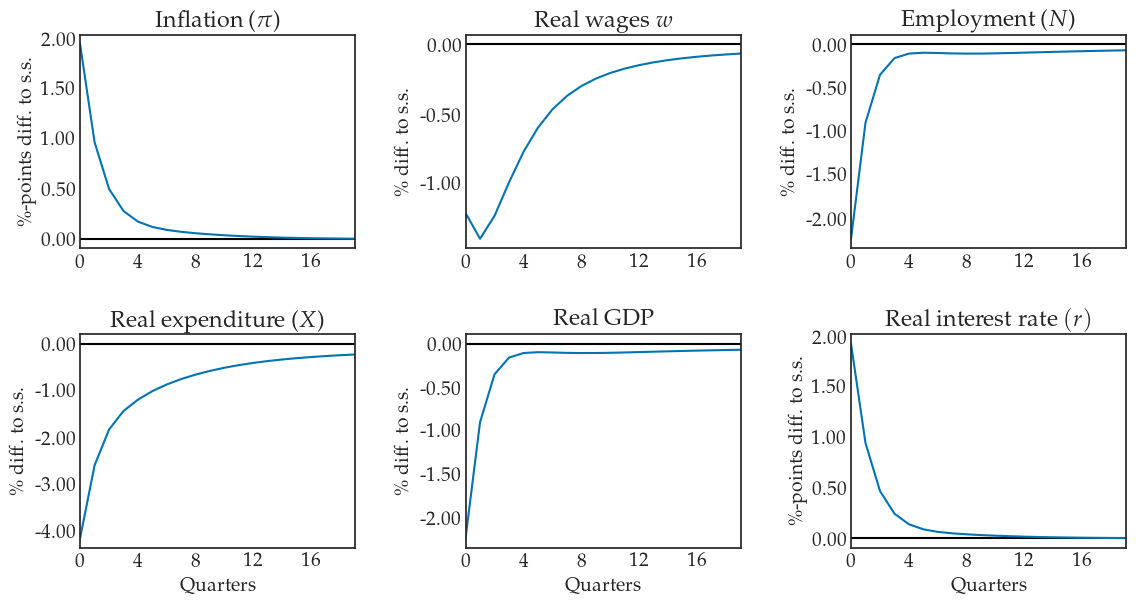

In [17]:
paths_ = ['P', 'W', 'w', 'X', 'YH', 'N']
paths_ = ['pi',  'w', 'N', 'X', 'YH',  'r_real']
fig = figs.show_IRFs([model_CD], paths_, T_max=T_max_)

if save_figs: fig.savefig('plots_defence/MAIN_CB_slides.png', dpi=300, bbox_inches='tight')

Other Results 

In [ ]:
paths_ = ['p', 'pi', 'r_real', 'Q', 'E', 'PTH_s', 'CTH_s']

fig = figs.show_IRFs(models,paths_)
fig.savefig('plots_defence/EXTRA_1.png', dpi=300, bbox_inches='tight')

State dependence

In [6]:
state_X_CD, state_X_CD_NH, state_CNT_CT_CD_CNT = figs.show_states(model_CD, shock, model_alt=model_NH, T_max=20)


# state_X_CD.savefig('plots_defence/state_X_CD.png', dpi=300, bbox_inches='tight')
# state_X_CD_NH.savefig('plots_defence/state_X_CD_NH.png', dpi=300, bbox_inches='tight')
# state_CNT_CT_CD_CNT.savefig('plots_defence/state_CNT_CT_CD_CNT.png', dpi=300, bbox_inches='tight')


: 

### PIGL

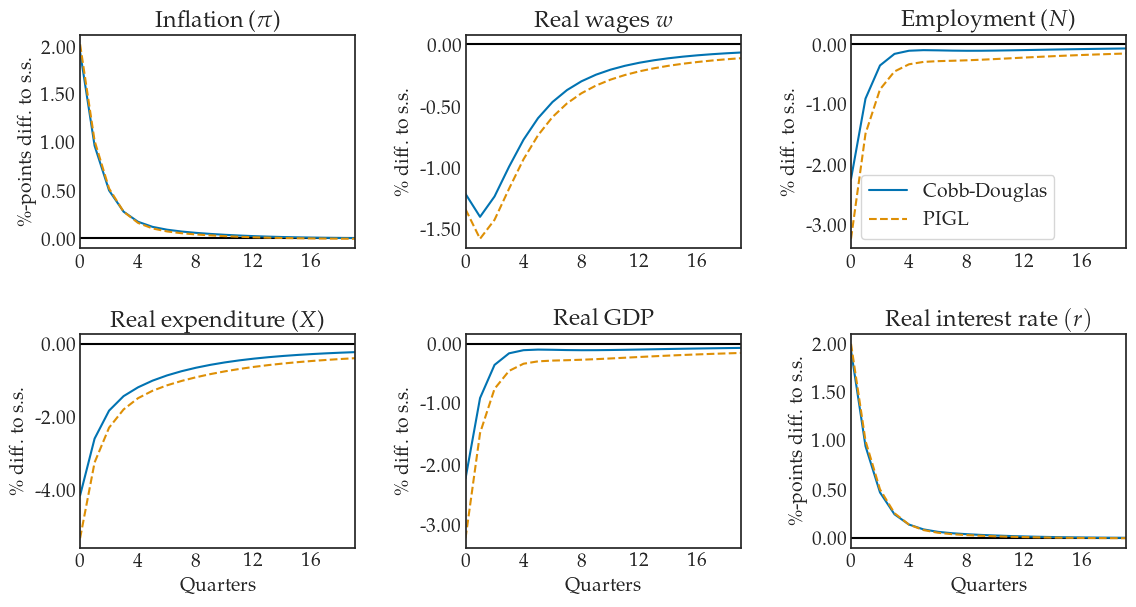

In [16]:
# Just testing
models = [model_CD, model_NH]
paths_ = ['pi',  'w', 'N', 'X', 'YH',  'r_real']

fig = figs.show_IRFs(models, paths_, T_max=T_max_, legend_window=2)
fig.savefig('plots_defence/MAIN_compare.png', dpi=300, bbox_inches='tight')

In [ ]:
models = [model_CD, model_NH]

paths_ = ['pi', 'w', 'X']
fig = figs.show_IRFs(models, paths_, T_max=T_max_, legend_window=2)
if save_figs: fig.savefig('plots_defence/simple_compare.png', dpi=300, bbox_inches='tight')

In [ ]:
fig = figs.show_pi(model_NH)
if save_figs: fig.savefig('plots_defence/pi_MPC.png', dpi=300, bbox_inches='tight')

In [ ]:
paths_ = ['CT_hh', 'CNT_hh', 'PT', 'PNT']
fig =  figs.show_IRFs(models, paths_, maxcol=2, T_max=T_max_, lwidth=2.5)
if save_figs: fig.savefig(f'plots_defence/Consupmtion_T_NT.png', dpi=300, bbox_inches='tight')

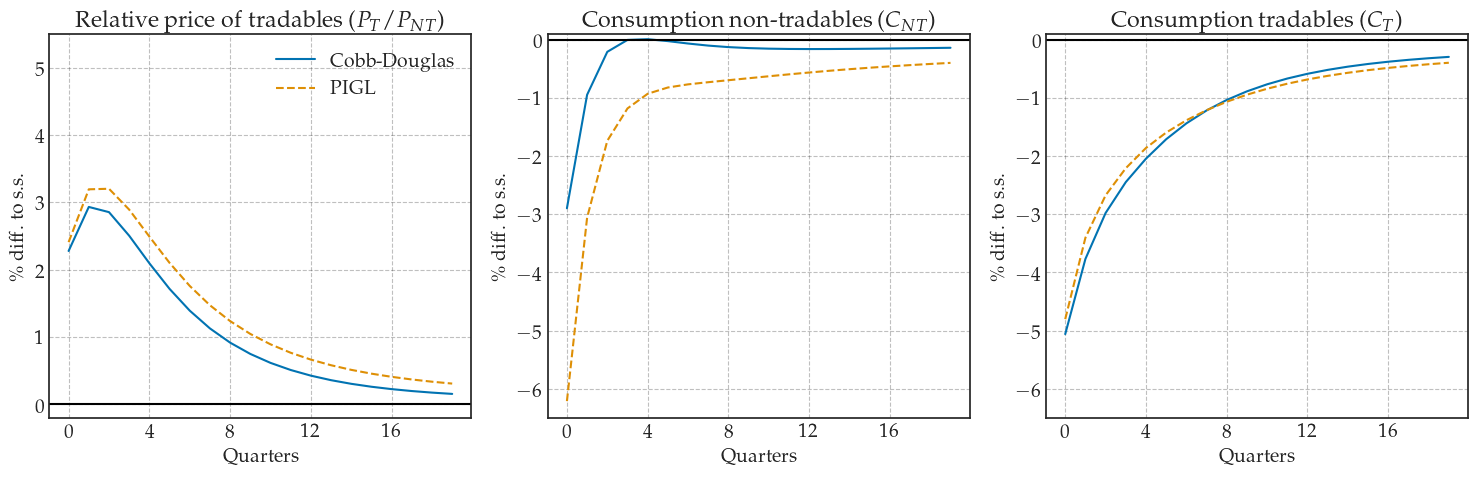

In [13]:
def show_C_p(models):
    fig = plt.figure(figsize=(15,5))


    # Paths (CT,CNT, PT, PNT)
    # CT 
    ax0 = fig.add_subplot(133)

    for i, model in enumerate(models):
        path = (model.path.__dict__['CT'] / model.ss.__dict__['CT'] - 1) * 100
        ls = '-' if i == 0 else '--'
        ax0.plot(path[:T_max_], label=model.name, ls=ls)
    ax0.set_ylabel('\% diff. to s.s.')
    ax0.set_title(r'Consumption tradables ($C_{T}$)')
    ax0.set_xlabel('Quarters')

    ax0.set_ylim(-6.5,0.1)
    ax0.set_xticks(np.arange(0, T_max_, 4))

    # Black line at 0
    ax0.axhline(0, color='black', linestyle='-')

    ax1 = fig.add_subplot(132)
    # CNT
    for i, model in enumerate(models):
        path = (model.path.__dict__['CNT'] / model.ss.__dict__['CNT'] - 1) * 100
        ls = '-' if i == 0 else '--'
        ax1.plot(path[:T_max_], label=model.name, ls=ls)
    ax1.set_ylabel('\% diff. to s.s.')
    ax1.set_title(r'Consumption non-tradables ($C_{NT}$)')
    ax1.set_xlabel('Quarters')
    ax1.set_ylim(-6.5,0.1)
    # ax1.legend()
    ax1.axhline(0, color='black', linestyle='-')

    ax1.set_xticks(np.arange(0, T_max_, 4))

    # PT 
    ax2 = fig.add_subplot(131)
    for i, model in enumerate(models):
        path = (model.path.__dict__['p'] / model.ss.__dict__['p'] - 1) * 100
        ls = '-' if i == 0 else '--'
        ax2.plot(path[:T_max_], label=model.name, ls=ls)
    ax2.set_ylabel('\% diff. to s.s.')
    ax2.set_title(r'Relative price of tradables ($P_{T}/P_{NT}$)')
    ax2.set_xlabel('Quarters')
    ax2.axhline(0, color='black', linestyle='-')
    ax2.set_xticks(np.arange(0, T_max_, 4))
    ax2.set_ylim(-0.2,5.5)
    ax2.legend()

  
    fig.tight_layout()
    return fig
    

fig = show_C_p(models)
if save_figs: fig.savefig('plots_defence/Consumption_p.png', dpi=300, bbox_inches='tight')

In [ ]:
def show_C_P(models):
    fig = plt.figure(figsize=(10,8.0))


    # Paths (CT,CNT, PT, PNT)
    # CT 
    ax0 = fig.add_subplot(221)

    for i, model in enumerate(models):
        path = (model.path.__dict__['CT'] / model.ss.__dict__['CT'] - 1) * 100
        ls = '-' if i == 0 else '--'
        ax0.plot(path[:T_max_], label=model.name, ls=ls)
    ax0.set_ylabel('\% diff. to s.s.')
    ax0.set_title(r'Consumption tradables ($C_{T}$)')
    ax0.set_xlabel('Quarters')

    ax0.set_ylim(-6.5,0.1)
    ax0.set_xticks(np.arange(0, T_max_, 4))

    # Black line at 0
    ax0.axhline(0, color='black', linestyle='-')

    ax1 = fig.add_subplot(222)
    # CNT
    for i, model in enumerate(models):
        path = (model.path.__dict__['CNT'] / model.ss.__dict__['CNT'] - 1) * 100
        ls = '-' if i == 0 else '--'
        ax1.plot(path[:T_max_], label=model.name, ls=ls)
    ax1.set_ylabel('\% diff. to s.s.')
    ax1.set_title(r'Consumption non-tradables ($C_{NT}$)')
    ax1.set_xlabel('Quarters')
    ax1.set_ylim(-6.5,0.1)
    # ax1.legend()
    ax1.axhline(0, color='black', linestyle='-')

    ax1.set_xticks(np.arange(0, T_max_, 4))

    # PT 
    ax2 = fig.add_subplot(223)
    for i, model in enumerate(models):
        path = (model.path.__dict__['PT'] / model.ss.__dict__['PT'] - 1) * 100
        ls = '-' if i == 0 else '--'
        ax2.plot(path[:T_max_], label=model.name, ls=ls)
    ax2.set_ylabel('\% diff. to s.s.')
    ax2.set_title(r'Price tradables ($P_{T}$)')
    ax2.set_xlabel('Quarters')
    ax2.axhline(0, color='black', linestyle='-')
    ax2.set_xticks(np.arange(0, T_max_, 4))
    ax2.set_ylim(-0.2,5.5)
    ax2.legend()

    # PNT
    ax3 = fig.add_subplot(224)
    for i, model in enumerate(models):
        path = (model.path.__dict__['PNT'] / model.ss.__dict__['PNT'] - 1) * 100
        ls = '-' if i == 0 else '--'
        ax3.plot(path[:T_max_], label=model.name, ls=ls)
    ax3.set_ylabel('\% diff. to s.s.')
    ax3.set_title(r'Price non-tradables ($P_{NT}$)')
    ax3.set_xlabel('Quarters')
    ax3.set_xticks(np.arange(0, T_max_, 4))
    ax3.axhline(0, color='black', linestyle='-')
    ax3.set_ylim(-0.2,5.5)

    

    fig.tight_layout()
    return fig
    

    
fig = show_C_P(models)
if save_figs: fig.savefig('plots_defence/Consumption_PT_PNT.png', dpi=300, bbox_inches='tight')

In [ ]:

def _plot_IRFs(ax,model,pathname,scale,lstyle,color,lwidth,label,T_max):



    # ssvalue and pathvalue
    ssvalue = getattr(model.ss,pathname)  
    pathvalue = getattr(model.path,pathname)
    dpathvalue = pathvalue - ssvalue

    T_max = np.fmin(pathvalue.size,T_max)
    
    # plot
    if pathname in abs_value:                     
    
        ax.plot(np.arange(T_max),(dpathvalue[:T_max])*scaleval,label=label,linestyle=lstyle,color=color,lw=lwidth)
        ax.set_ylabel('abs. diff. to s.s.')
        ax.set_title(pathlabel)
    
    elif pathname in pctp:
    
        ax.plot(np.arange(T_max),100*(dpathvalue[:T_max])*scaleval,label=label,linestyle=lstyle,color=color,lw=lwidth)
        ax.set_ylabel('\%-points diff. to s.s.')
        ax.set_title(pathlabel)
    
    # elif pathname == 'NX':   
        
    #     pathvalue_IM = getattr(model.path,'Imports')   
    #     pathvalue_EX = getattr(model.path,'Exports')  
    #     ssvalue_IM = getattr(model.ss,'Imports')
    #     ssvalue_EX = getattr(model.ss,'Exports')
    #     dIM = 100*(pathvalue_IM[:T_max]-ssvalue_IM)*scaleval / ssvalue_IM  
    #     dEX = 100*(pathvalue_EX[:T_max]-ssvalue_EX)*scaleval / ssvalue_EX      
    #     dNX = dEX-dIM  
    #     ax.plot(np.arange(T_max),dNX,label=label,linestyle=lstyle,color=color,lw=lwidth)
    #     ax.set_ylabel('\% diff. to s.s.')
    #     ax.set_title(pathlabel)

    else:

        if abs(ssvalue) > 0: 
        
            ax.plot(np.arange(T_max),((dpathvalue[:T_max])*scaleval/ssvalue)*100,label=label, linestyle=lstyle,color=color,lw=lwidth)
            ax.set_ylabel('\% diff. to s.s.')
            ax.set_title(pathlabel)
        
        else:
        
            ax.plot(np.arange(T_max),((dpathvalue[:T_max])*scaleval)*100,label=label, linestyle=lstyle, color=color,lw=lwidth)
            ax.set_ylabel('\% diff. to s.s.')
            ax.set_title(pathlabel)                           


def show_IRFs(models,paths=None,
            #   labels=None,
              T_max=20,scale=False,
              lwidth=1.5,lstyles=None,colors=None,
              maxcol=3,figsize=None,
              lfsize=12,legend_window=0,
              compare_LP=None,CI=False,do_stds=False,show=True):

    # a. models as list
    if type(models) is dict: models = [model for model in models.values()]
    model = models[0]
    par = model.par



    # b. inputs
    # if paths is None: paths = paths_defaults['standard_vs_data']
    # if type(paths) is str: paths = paths_defaults[paths]
    # if labels is None: labels = [None]*len(models)
    # assert len(labels) >= len(models), f'{len(labels) = } must be same as {len(models) = }'
    if lstyles is None: lstyles = ['-','--','-.',':',(0,(3, 1, 1, 1)),(0,(3, 5, 1, 5, 1, 5))]    
    if T_max is None: T_max = par.T   
    T_max_LP = 17
    labels = []
    for i in models:
        labels.append(i.name)

    # c. figure
    num = len(paths)
    nrows = num//maxcol+1
    ncols = np.fmin(num,maxcol)
    if num%maxcol == 0: nrows -= 1 

#***** FiGURE SIZE
    if figsize is None:
        #fig = plt.figure(figsize=(4.3*ncols,3.6*nrows))
        x_size, y_size = 13.5/maxcol*ncols, 10/maxcol*nrows
        fig = plt.figure(figsize=(x_size, y_size), dpi=100)
    else:
        fig = plt.figure(figsize=(figsize[0]*ncols,figsize[1]*nrows))

    for i,pathname in enumerate(paths):


        ax = fig.add_subplot(nrows,ncols,i+1)

        # axis
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        if T_max < 30:
            ax.set_xticks(np.arange(0,T_max,4))
        else:
            ax.set_xticks(np.arange(0,T_max,8))
        
        # models
        for j, model_ in enumerate(models):  
            
            if lstyles is None:
                lstyle = '-' 
            else:
                lstyle = lstyles[j]

            if not colors is None:
                color = colors[j]
            else:
                color = f'C{j}'

            label = labels[j]

            if j == 0: ax.plot(np.arange(T_max),np.zeros(T_max),'-', color='black')
            _plot_IRFs(ax,model_,pathname,scale,lstyle,color,lwidth,label,T_max)

            ax.set_xlim([0,T_max-1])
            # if pathname == 'CT': 
            #     ax.set_ylim = [-0.7, 0.1]

            if i >= ncols*(nrows-1): ax.set_xlabel('Quarters')
            
        if compare_LP is not None:

            try:

                ax.plot(np.arange(T_max_LP),compare_LP['IRF'][pathname][:T_max_LP]*100,label='LP',
                        linestyle='--',color='black',lw=lwidth)
                
                if do_stds:

                    if CI:

                        prob=0.05
                        sign = norm.ppf(1-prob/2)
                        SE = compare_LP['SE'][pathname]
                        LO = compare_LP['IRF'][pathname] - SE
                        HI = compare_LP['IRF'][pathname] + SE
                        ax.fill_between(np.arange(T_max_LP), LO[:T_max_LP], HI[:T_max_LP], alpha=0.15, color='C0')
                        LO = compare_LP['IRF'][pathname] - sign*SE
                        HI = compare_LP['IRF'][pathname] + sign*SE
                        ax.fill_between(np.arange(T_max_LP), LO[:T_max_LP], HI[:T_max_LP], alpha=0.08, color='C0')
                
                else:

                    if CI:

                        LO = compare_LP['IRF'][pathname] + compare_LP['LO'][pathname][:,0]*100  
                        HI = compare_LP['IRF'][pathname] + compare_LP['HI'][pathname][:,0]*100  
                        ax.fill_between(np.arange(T_max_LP), LO[:T_max_LP], HI[:T_max_LP], alpha=0.25, color='C0')
                        LO = compare_LP['IRF'][pathname] + compare_LP['LO'][pathname][:,1]*100  
                        HI = compare_LP['IRF'][pathname] + compare_LP['HI'][pathname][:,1]*100  
                        ax.fill_between(np.arange(T_max_LP), LO[:T_max_LP], HI[:T_max_LP], alpha=0.15, color='C0')
            
            except:
                
                pass

        if len(models) > 1:
            if i == legend_window: ax.legend(frameon=True)

    #fig.tight_layout(pad=1.0)
    fig.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(wspace=0.4)
    if show : plt.show()

    return fig

show_IRFs([model_CD], paths_)


# Other simulations 

In [ ]:
paths__ = ['']
fig = 

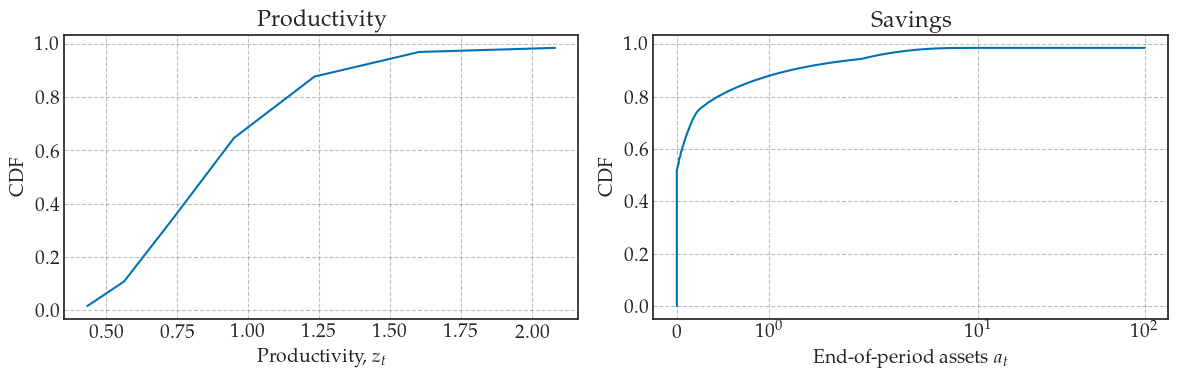

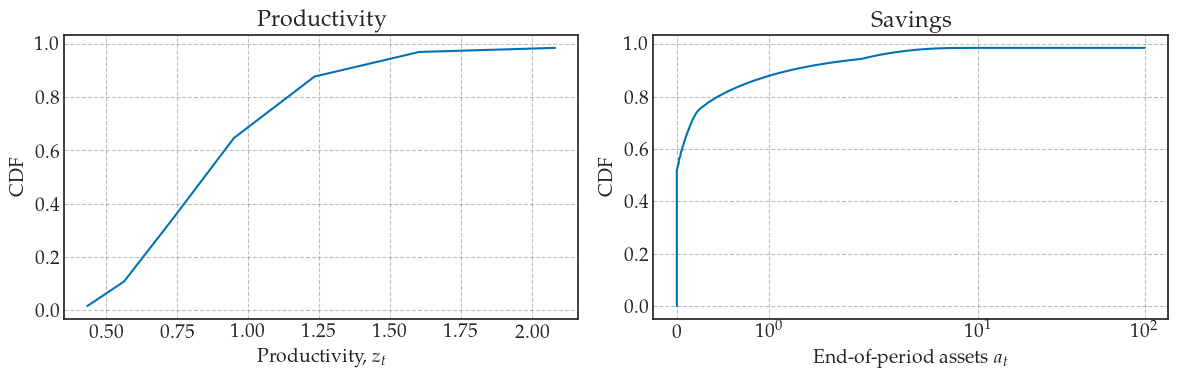

In [64]:
figs.cum_z_a(model_NH)

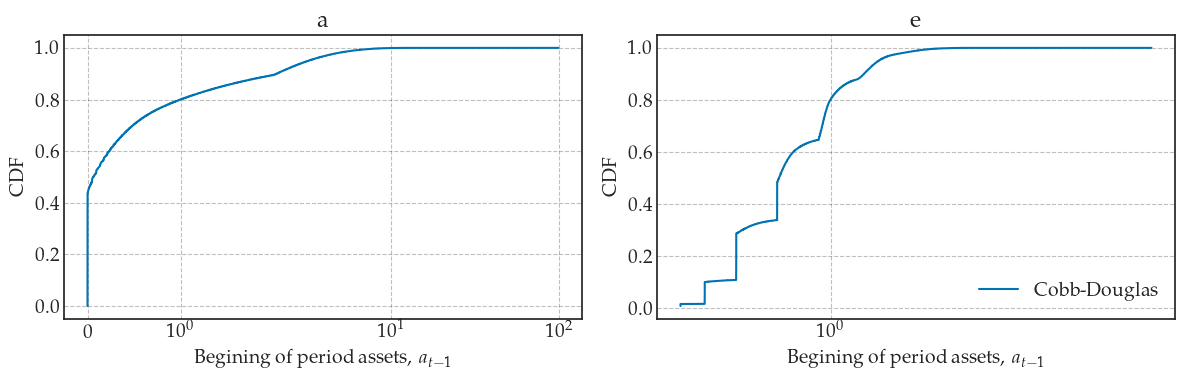

In [70]:
fig = figs.plot_cum([model_CD], ['a', 'e'])
fig.savefig('plots_defence/CDF.png', dpi=300, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


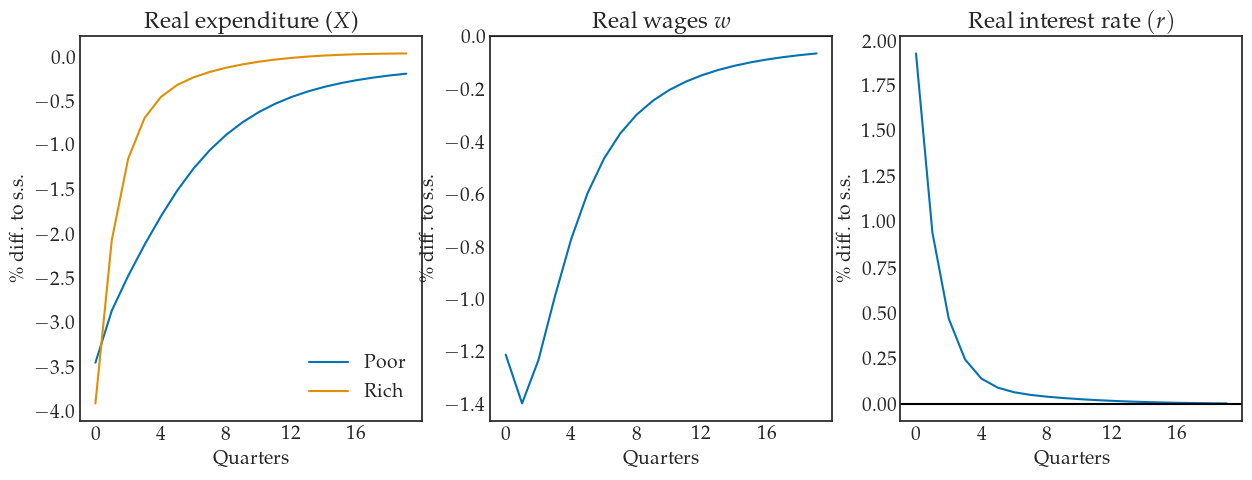

In [29]:



def show_states_inc_r(model, shock, model_alt=None, states=None, T_max=20):
    if states is None:
        states = {
            'Poor': [0, 0, 0],
            'Rich': [0, 6, 300]
        }

    # ======= Initialize result dictionaries ========
    CT_diff, CNT_diff, E_hh_diff, Q_diff, X_diff, A_diff = {}, {}, {}, {}, {}, {}
    CT_diff_alt, CNT_diff_alt, E_hh_diff_alt, Q_diff_alt, X_diff_alt, A_diff_alt = {}, {}, {}, {}, {}, {}

    # === Base model ===
    model_base = model.copy(name=model.name)
    model_base.find_ss()
    model_base.compute_jacs()

    model_ns = model_base.copy(name='NoShock')
    model_ns.find_transition_path(shocks=[], do_end_check=False)

    model_s = model_base.copy(name='Shock')
    model_s.find_transition_path(shocks=shock, do_end_check=False)

    for state in states:
        s0, s1, s2 = states[state]

        Dbeg_choice = np.zeros(model.ini.Dbeg.shape)
        for i in [0, 1]:
            Dbeg_choice[i, s1, s2] = 1.0
        Dbeg_choice /= Dbeg_choice.sum()

        model_ns.simulate_hh_path(Dbeg=Dbeg_choice)
        model_ns.calc_additional_new()

        model_s.simulate_hh_path(Dbeg=Dbeg_choice)
        model_s.calc_additional_new()

        CT_diff[state] = (model_s.path.CT_hh - model_ns.path.CT_hh) / model_ns.path.CT_hh * 100
        CNT_diff[state] = (model_s.path.CNT_hh - model_ns.path.CNT_hh) / model_ns.path.CNT_hh * 100
        E_hh_diff[state] = (model_s.path.E_hh - model_ns.path.E_hh) / model_ns.path.E_hh * 100
        Q_diff[state] = (model_s.path.Q_hh - model_ns.path.Q_hh) / model_ns.path.Q_hh * 100
        X_diff[state] = (model_s.path.X_hh - model_ns.path.X_hh) / model_ns.path.X_hh * 100
        A_diff[state] = (model_s.path.A_hh - model_ns.path.A_hh)  # no percent

    # del model_ns, model_s
    # gc.collect()

    # === Alternative model ===
    if model_alt is not None:
        model_base_alt = model_alt.copy(name=model_alt.name)
        model_base_alt.find_ss()
        model_base_alt.compute_jacs()

        for state in states:
            s0, s1, s2 = states[state]

            Dbeg_choice = np.zeros(model.ini.Dbeg.shape)
            for i in [0, 1]:
                Dbeg_choice[i, s1, s2] = 1.0
            Dbeg_choice /= Dbeg_choice.sum()

            model_ns_alt = model_base_alt.copy(name='NoShock Homo')
            model_ns_alt.find_transition_path(shocks=[])
            model_ns_alt.simulate_hh_path(Dbeg=Dbeg_choice)
            model_ns_alt.calc_additional_new()

            model_s_alt = model_base_alt.copy(name='Shock Homo')
            model_s_alt.find_transition_path(shocks=shock, do_end_check=False)
            model_s_alt.simulate_hh_path(Dbeg=Dbeg_choice)
            model_s_alt.calc_additional_new()

            CT_diff_alt[state] = (model_s_alt.path.CT_hh - model_ns_alt.path.CT_hh) / model_ns_alt.path.CT_hh * 100
            CNT_diff_alt[state] = (model_s_alt.path.CNT_hh - model_ns_alt.path.CNT_hh) / model_ns_alt.path.CNT_hh * 100
            E_hh_diff_alt[state] = (model_s_alt.path.E_hh - model_ns_alt.path.E_hh) / model_ns_alt.path.E_hh * 100
            Q_diff_alt[state] = (model_s_alt.path.Q_hh - model_ns_alt.path.Q_hh) / model_ns_alt.path.Q_hh * 100
            X_diff_alt[state] = (model_s_alt.path.X_hh - model_ns_alt.path.X_hh) / model_ns_alt.path.X_hh * 100
            A_diff_alt[state] = (model_s_alt.path.A_hh - model_ns_alt.path.A_hh) / model_ns_alt.path.A_hh * 100

        del model_ns_alt, model_s_alt
        gc.collect()

    # === Plotting ===
    color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    state_colors = {state: next(color_cycle) for state in states}

    # --- Fig 1: Real Expenditure Only ---
    fig_1 = plt.figure(figsize=(15,5))


    ax = fig_1.add_subplot(1, 3, 1)
    for state in states:
        ax.plot(X_diff[state][:T_max], color=state_colors[state], label=state)
    # if model_alt is not None:
    #     for state in states:
    #         ax.plot(X_diff_alt[state][:T_max], color=state_colors[state], linestyle='--')
    ax.set_ylabel('\% diff. to s.s.')
    ax.set_title(r'Real expenditure ($X$)')
    ax.set_xlabel('Quarters')
    ax.legend()
    ax.set_xticks(np.arange(0, T_max, 4))

    ax1 = fig_1.add_subplot(132)
    # CNT
    
    path = (model_s.path.__dict__['w'] / model_s.ss.__dict__['w'] - 1) * 100
    ax1.plot(path[:T_max_])
    ax1.set_ylabel('\% diff. to s.s.')
    ax1.set_title(r'Real wages $w$')
    ax1.set_xlabel('Quarters')

    # ax1.legend()
    ax1.axhline(0, color='black', linestyle='-')

    ax1.set_xticks(np.arange(0, T_max_, 4))

    # PT 
    ax2 = fig_1.add_subplot(133)
    path = (model_s.path.__dict__['r_real'] - model_s.ss.__dict__['r_real'] )*100
    ax2.plot(path[:T_max_])
    
    ax2.set_ylabel('\%-points diff. to s.s.')
    ax2.set_title(r'Real interest rate $(r)$')
    ax2.set_xlabel('Quarters')
    ax2.axhline(0, color='black', linestyle='-')
    ax2.set_xticks(np.arange(0, T_max_, 4))

    ax2.legend()


    fig_1.tight_layout()

    return fig_1



fig = show_states_inc_r(model_CD, shock)
fig.savefig('plots_defence/states_inc_r.png', dpi=300, bbox_inches='tight')

In [30]:
model_e1 = IHANKModelClass(name='epsion = 0.10')
model_e1.par.epsilon = 0.10
# model_e1.par.gamma = 0.24
model_e1.find_ss()
model_e1.compute_jacs()
model_e1.find_transition_path(shocks=shock, do_end_check=False)

model_e05 = IHANKModelClass(name='epsion = 0.05')
model_e05.par.epsilon = 0.05
# model_e05.par.gamma = 0.21
model_e05.find_ss()
model_e05.compute_jacs()
model_e05.find_transition_path(shocks=shock, do_end_check=False)

model_e00 = IHANKModelClass(name='epsion = 0.0')
model_e00.par.epsilon = 0.0
model_e00.find_ss()
model_e00.compute_jacs()
model_e00.find_transition_path(shocks=shock, do_end_check=False)


# colors_reds = sns.color_palette("Reds", n_colors=5)
# fig = figs.show_IRFs(models, paths=['P', 'X', 'CT', 'CNT' ], colors = colors_reds, maxcol=2)
# if save_figs: fig.savefig('plots/IRFs_epsion.png', dpi=300, bbox_inches='tight')

$\epsilon =$ 0.22
$\epsilon =$ 0.10
$\epsilon =$ 0.05
$\epsilon =$ 0.00


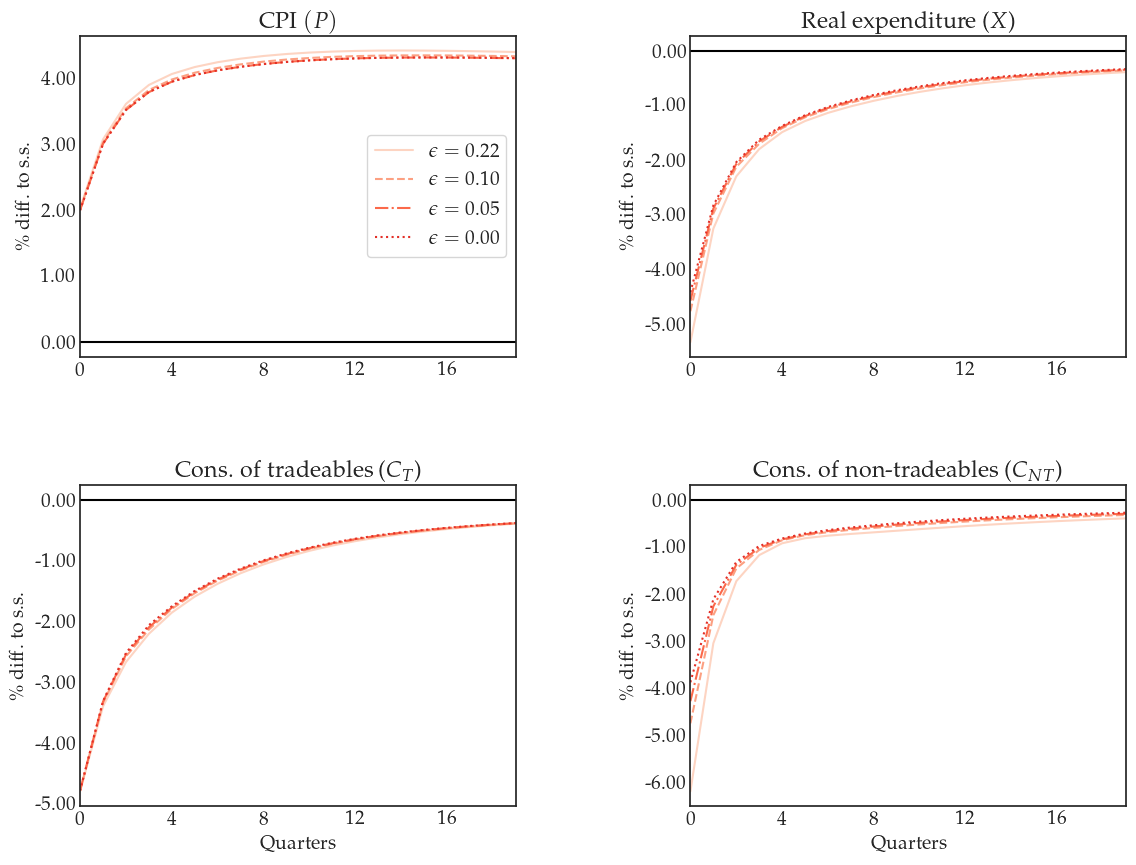

In [35]:
models = [model_NH,  model_e1, model_e05 , model_e00]#, model_homothetic]
for model_i in models:
    # model_i.calc_additional_new()
    model_i.name =  r'$\epsilon =$' + f' {model_i.par.epsilon:.2f}'    
    print(model_i.name)

    # '$\gamma = 0.1$'
    # model_i.name = f'cov = {model_i.cov_e_omegaT:.3f}'
colors_reds = sns.color_palette("Reds", n_colors=5)
fig = figs.show_IRFs(models, paths=['P', 'X', 'CT', 'CNT' ], colors = colors_reds, maxcol=2)
if save_figs: fig.savefig('plots_defence/IRFs_epsion.png', dpi=300, bbox_inches='tight')


In [36]:
fig = figs.plot_eta_T_RA_vs_gamma()

: 

In [7]:
model_g1 = IHANKModelClass(name='$\gamma = 0.1$')
model_g1.par.epsilon = 0.0
model_g1.par.gamma = 0.10
model_g1.find_ss()
model_g1.compute_jacs()
model_g1.find_transition_path(shocks=shock, do_end_check=False)


In [8]:
model_g2 = IHANKModelClass(name='$\gamma = 0.2$')
model_g2.par.epsilon = 0.0
model_g2.par.gamma = 0.20
model_g2.find_ss()
model_g2.compute_jacs()
model_g2.find_transition_path(shocks=shock, do_end_check=False)

In [9]:
model_g25 = IHANKModelClass(name='$\gamma = 0.25$')
model_g25.par.epsilon = 0.0
model_g25.par.gamma = 0.25
model_g25.find_ss()
model_g25.compute_jacs()
model_g25.find_transition_path(shocks=shock, do_end_check=False)

In [10]:
model_g3 = IHANKModelClass(name='$\gamma = 0.3$')
model_g3.par.epsilon = 0.0
model_g3.par.gamma = 0.3
model_g3.find_ss()
model_g3.compute_jacs()
model_g3.find_transition_path(shocks=shock, do_end_check=False)

: 

In [ ]:
model_CD.name = '$\gamma = 0.0$'

models = [model_CD,  model_g2,   model_g3]
for model_i in models:
    model_i.calc_additional_new()
    model_i.name = f'$\eta_T$ = {model_i.par.eta_T_RA:.2f}'
    
colors_reds = sns.color_palette("Reds", n_colors=4)
path_eta = ['CT', 'CNT', 'X'] 


fig = figs.show_IRFs(models, path_eta, maxcol=3)
if save_figs: fig.savefig('plots_defence/gamma_CD.png', dpi=300, bbox_inches='tight')

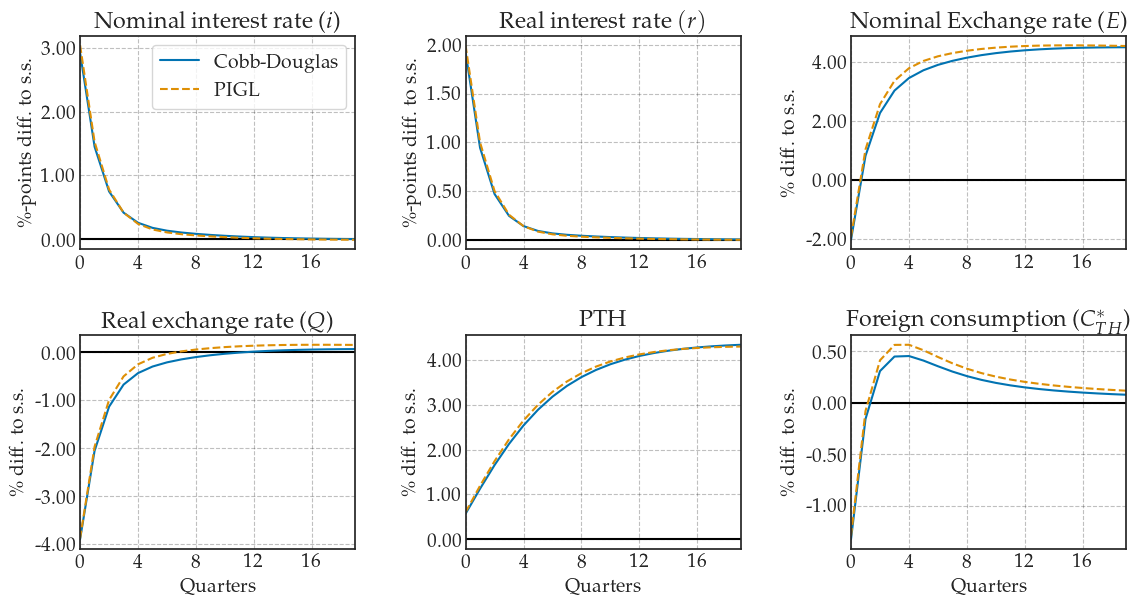

In [7]:


paths_forigne = ['i', 'r_real', 'E', 'Q', 'PTH', 'CTH_s' ]

fig = figs.show_IRFs(models, paths_forigne)
fig.savefig('plots_defence/forigne.png', dpi=300, bbox_inches='tight')

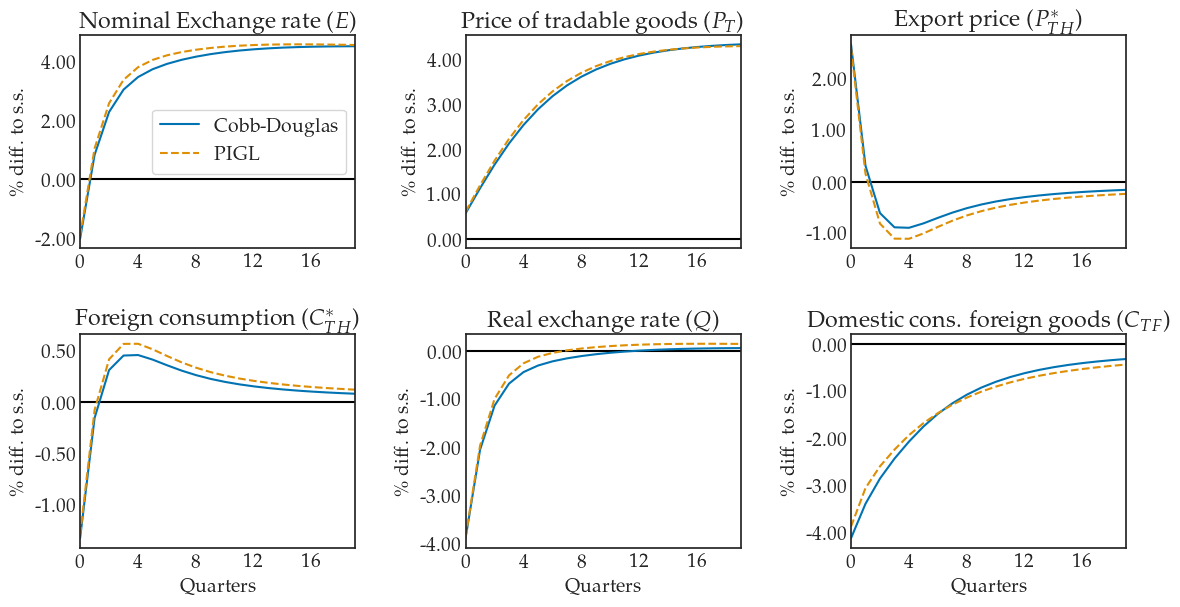

In [79]:


paths_forigne = [ 'E','PTH', 'PTH_s', 'CTH_s', 'Q', 'CTF'  ]

fig = figs.show_IRFs(models, paths_forigne)
fig.savefig('plots_defence/forigne_.png', dpi=300, bbox_inches='tight')

In [8]:
model_NH.par.eta_T_RA

0.702553352748842

In [10]:
model_NH.par.gamma

0.25

In [46]:
gamma_i = 0.14



model_alt = IHANKModelClass()
model_alt.par.epsilon = 0.0
model_alt.par.gamma = gamma_i
model_alt.find_ss()
print(model_alt.par.eta_T_RA)

0.6626506024096386


In [47]:
model_alt.par.gamma = 0.11
model_alt.find_ss()
model_alt.compute_jacs()
model_alt.find_transition_path(shock)

E: terminal value is   1.04177659, but ss value is   1.00000000
CB: terminal value is   1.04177659, but ss value is   1.00000000
WTH: terminal value is   0.94706963, but ss value is   0.90909091
WNT: terminal value is   0.94706963, but ss value is   0.90909091
PTH: terminal value is   1.04177659, but ss value is   1.00000000
PNT: terminal value is   1.04177659, but ss value is   1.00000000
PF: terminal value is   1.04177659, but ss value is   1.00000000
PT: terminal value is   1.04177659, but ss value is   1.00000000
P: terminal value is   1.04177659, but ss value is   1.00000000
PE: terminal value is   1.04177659, but ss value is   1.00000000
PTHF: terminal value is   1.04177659, but ss value is   1.00000000
DomP: terminal value is   1.04177659, but ss value is   1.00000000
B: terminal value is   0.66859095, but ss value is   0.64177958
div_TH: terminal value is   0.04500431, but ss value is   0.04319958
div_NT: terminal value is   0.04970265, but ss value is   0.04770951
A: terminal 

In [50]:
model_alt.name = f'Homothetic lower $\eta_T$'

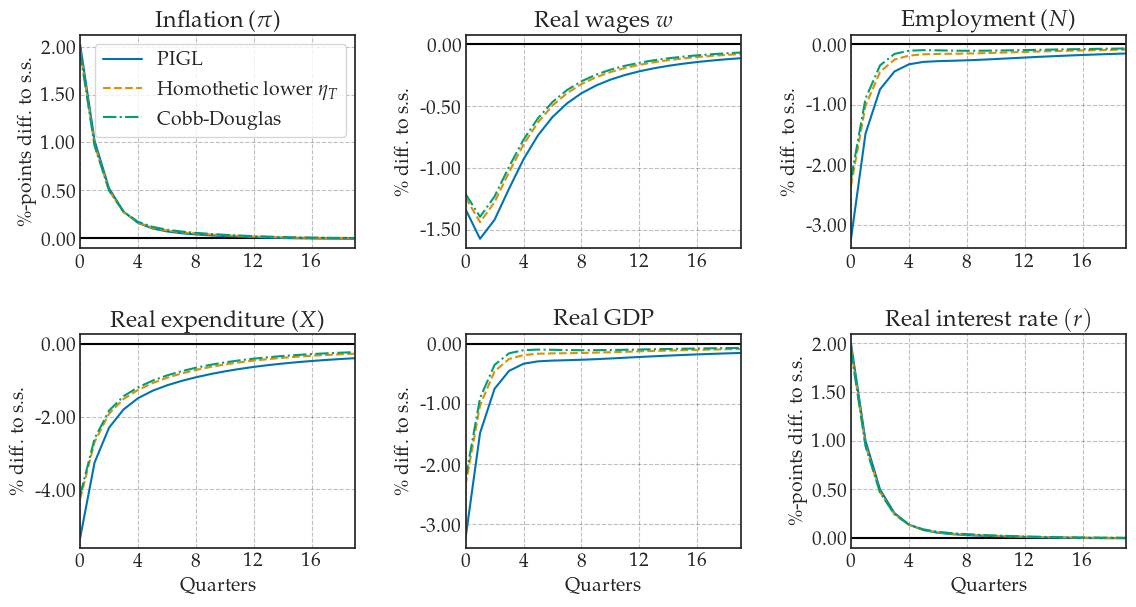

In [52]:
paths_ = ['pi',  'w', 'N', 'X', 'YH',  'r_real']
fig = figs.show_IRFs([model_NH,model_alt, model_CD], paths_)
fig.savefig('plots_defence/Homothetic_lower_etaT.png', dpi=300, bbox_inches='tight')

In [11]:
gamma_i = 0.15



model_alt = IHANKModelClass()
model_alt.par.epsilon = 0.0
model_alt.par.gamma = gamma_i
model_alt.find_ss()
print(model_alt.par.eta_T_RA)

0.6385542168674699


In [29]:
model_alt = IHANKModelClass()

In [30]:
model_alt.par.float = False
model_alt.find_ss()
model_alt.compute_jacs()
model_alt.find_transition_path(shock)


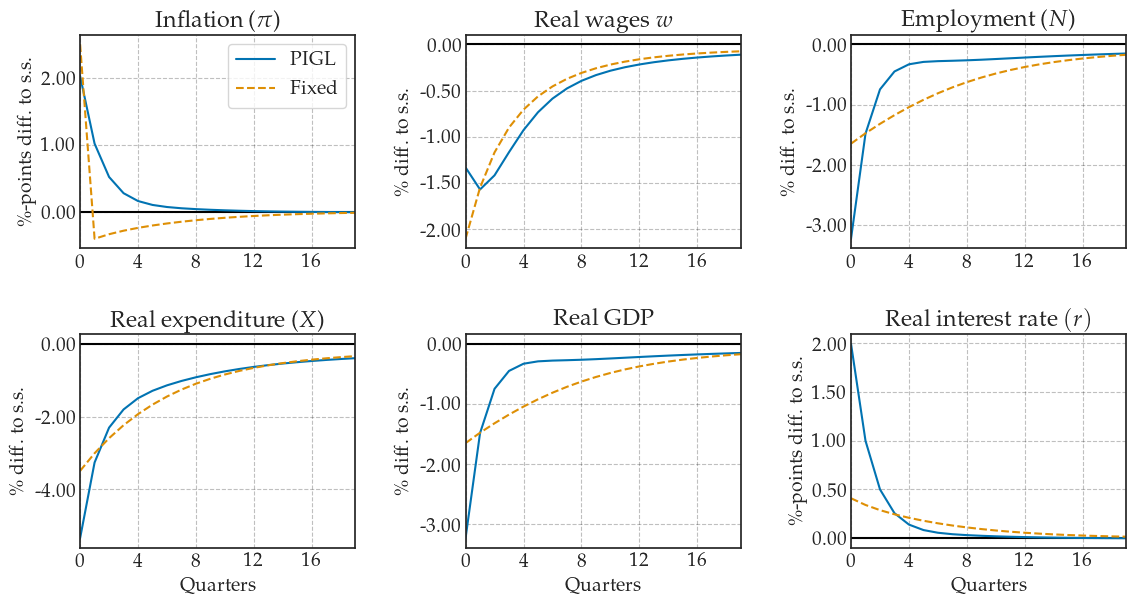

In [35]:


fig = figs.show_IRFs([model_NH,model_alt], paths_)
fig.savefig('plots_defence/Fixed_exchange_rate.png', dpi=300, bbox_inches='tight')

In [58]:
model_alt = IHANKModelClass(name= 'PIGL CES')
model_alt.par.gamma =  model_alt.par.epsilon
model_alt.find_ss()
model_alt.compute_jacs()
model_alt.find_transition_path(shock)

E: terminal value is   1.04126588, but ss value is   1.00000000
CB: terminal value is   1.04126588, but ss value is   1.00000000
WTH: terminal value is   0.94660535, but ss value is   0.90909091
WNT: terminal value is   0.94660535, but ss value is   0.90909091
PTH: terminal value is   1.04126588, but ss value is   1.00000000
PNT: terminal value is   1.04126588, but ss value is   1.00000000
PF: terminal value is   1.04126588, but ss value is   1.00000000
PT: terminal value is   1.04126588, but ss value is   1.00000000
P: terminal value is   1.04126588, but ss value is   1.00000000
PE: terminal value is   1.04126588, but ss value is   1.00000000
PTHF: terminal value is   1.04126588, but ss value is   1.00000000
DomP: terminal value is   1.04126588, but ss value is   1.00000000
B: terminal value is   0.34167248, but ss value is   0.32813183
div_TH: terminal value is   0.04665156, but ss value is   0.04480273
div_NT: terminal value is   0.04800898, but ss value is   0.04610636
A: terminal 

In [59]:
model_alt.par.eta_T_RA

0.78

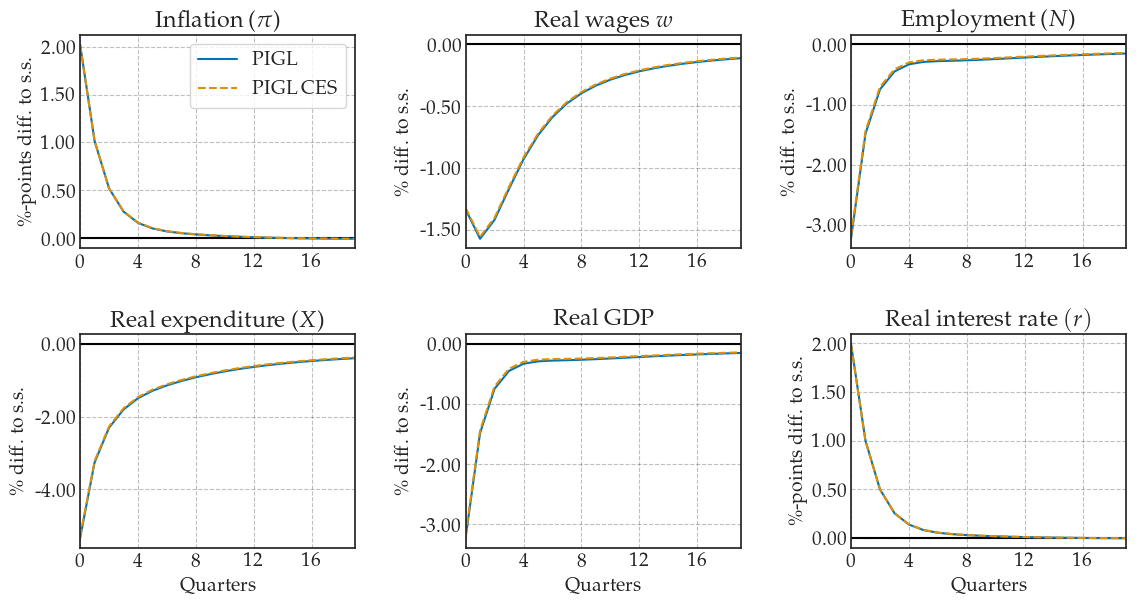

In [60]:
fig = figs.show_IRFs([model_NH, model_alt], paths_)
fig.savefig('plots_defence/IRFs_CES.png', dpi=300, bbox_inches='tight')


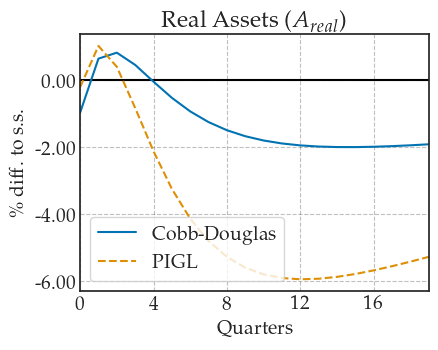

In [63]:
paths__ = ['A_real']
fig = figs.show_IRFs(models, paths__, T_max=20)